In [1]:
%load_ext autoreload
%autoreload 2


# Introduction to Le Wagon Project

## Import Packages

In [98]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

import glob
import requests
from bs4 import BeautifulSoup


## Keep track of things to do:

    Goal for Monday - have the baseline data ready to play with (clean financials, list of key variables to 
    take, merged and clean price data).
    
    1) Automate pulling data from SEC to include new data as it is included (later)
    2) Set up code to pull and clean SEC data from folder (Chris)
    3) Set up API to pull data from polygon.io and set up historic price data (Eoin)
    4) Find missing price data (Eoin & Reza)
    5) FRED macro data (Daryoosh)
    6) CME Fedwatch?? Available for the last year (later)
    7) Extensions
    
    * Sense check on line items and stock prices vs. external data

## Data Collection

### Formulas

In [3]:
def tag_check(tag, list):
    if tag in list:
        return 1
    return 0

### Corporate Financial Data

The jumping off point will be from EDGAR:

* https://www.sec.gov/data-research/financial-statement-notes-data-sets
* https://www.sec.gov/about/dera_financial-statement-data-set

#### Introduction

See data relationships below:


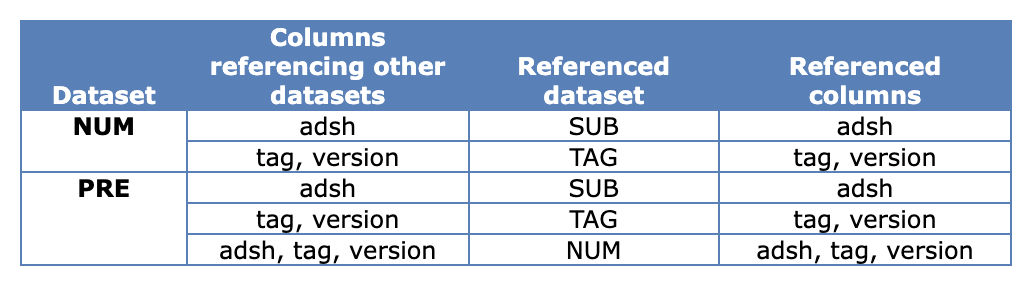

Retry with Selenium:


    url = 'https://www.sec.gov/about/dera_financial-statement-data-set'
    content = requests.get(url).content
    soup = BeautifulSoup(content)
    links = soup.find_all('a', href=True)
    links

#### Building Raw Data

In [4]:
agg_path = '../raw_data/SEC_data/Simple/Aggregated/'
sec_path = '../raw_data/SEC_data/Simple/Unzipped/'

folders = sorted(os.listdir(sec_path))[1:]

In [5]:
# Financial Statements Data
contents = {'pre.txt': [],
          'sub.txt': [],
          'tag.txt': [],
          'num.txt': []}

# Financial Statements Data with Notes
#contents = {'ren.tsv': [],
#          'pre.tsv': [],
#          'sub.tsv': [],
#          'txt.tsv': [],
#          'cal.tsv': [],
#          'tag.tsv': [],
#          'dim.tsv': [],
#          'num.tsv': []}

In [6]:
files = {f: os.listdir(sec_path+f) for f in folders}


for i, k in enumerate(files):
    for f in glob.glob(sec_path+k+'/*.txt'):
        file = f.split('/')[-1]
        contents[file].append(f)

# Visualize folders
display(contents.keys())
contents.get('num.txt')

dict_keys(['pre.txt', 'sub.txt', 'tag.txt', 'num.txt'])

['/Users/christophernance/code/cnance09/Small-Cap-Scout/raw_data/SEC_data/Simple/Unzipped/2009q1/num.txt',
 '/Users/christophernance/code/cnance09/Small-Cap-Scout/raw_data/SEC_data/Simple/Unzipped/2009q2/num.txt',
 '/Users/christophernance/code/cnance09/Small-Cap-Scout/raw_data/SEC_data/Simple/Unzipped/2009q3/num.txt',
 '/Users/christophernance/code/cnance09/Small-Cap-Scout/raw_data/SEC_data/Simple/Unzipped/2009q4/num.txt',
 '/Users/christophernance/code/cnance09/Small-Cap-Scout/raw_data/SEC_data/Simple/Unzipped/2010q1/num.txt',
 '/Users/christophernance/code/cnance09/Small-Cap-Scout/raw_data/SEC_data/Simple/Unzipped/2010q2/num.txt',
 '/Users/christophernance/code/cnance09/Small-Cap-Scout/raw_data/SEC_data/Simple/Unzipped/2010q3/num.txt',
 '/Users/christophernance/code/cnance09/Small-Cap-Scout/raw_data/SEC_data/Simple/Unzipped/2010q4/num.txt',
 '/Users/christophernance/code/cnance09/Small-Cap-Scout/raw_data/SEC_data/Simple/Unzipped/2011q1/num.txt',
 '/Users/christophernance/code/cnance

In [ ]:
# Load in all Datasets - include logic to skip if aggregated csv is available

for i, v in enumerate(contents.get('pre.txt')):
    if i == 0:
        pre = pd.read_csv(v, sep='\t')
    else:
        tmp = pd.read_csv(v, sep='\t')
        pre = pd.concat((pre, tmp), axis=0)
pre.to_csv(agg_path+'pre_all.csv')
del pre

for i, v in enumerate(contents.get('tag.txt')):
    if i == 0:
        tag = pd.read_csv(v, sep='\t')
    else:
        tmp = pd.read_csv(v, sep='\t')
        tag = pd.concat((tag, tmp), axis=0)
tag.to_csv(agg_path+'tag_all.csv')
        
for i, v in enumerate(contents.get('sub.txt')):
    if i == 0:
        sub = pd.read_csv(v, sep='\t')
    else:
        tmp = pd.read_csv(v, sep='\t')
        sub = pd.concat((sub, tmp), axis=0)
sub.to_csv(agg_path+'sub_all.csv')



for i, v in enumerate(contents.get('num.txt')):
    if i == 0:
        num = pd.read_csv(v, sep='\t')
    else:
        tmp = pd.read_csv(v, sep='\t')
        num = pd.concat((num, tmp), axis=0)
num.to_csv(agg_path+'num_all.csv')   



#### Loading Raw Data

In [7]:
# Presentation of Statements (PRE)

pre = pd.read_csv(agg_path+'pre_all.csv', index_col=0)
pre_clean = pre[(pre.inpth==0)&(pre.negating==0)].drop(['inpth', 'rfile', 'plabel', 'negating'], axis=1).drop_duplicates()

pre_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 46006170 entries, 0 to 1391886
Data columns (total 6 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   adsh     object
 1   report   int64 
 2   line     int64 
 3   stmt     object
 4   tag      object
 5   version  object
dtypes: int64(2), object(4)
memory usage: 2.4+ GB


In [8]:
# Financial Line Item Tags (TAG) - consider only US GAAP Accounting Standards

tag = pd.read_csv(agg_path+'tag_all.csv', index_col=0)
tag_clean = tag[(tag.datatype=='monetary')&(tag.custom==0)][['tag', 'version', 'tlabel']].dropna().drop_duplicates()

tag_clean['us_gaap'] = tag_clean.version.apply(lambda x: 1 if 'us-gaap' in x else 0)
tag_gaap = tag_clean[tag_clean.us_gaap==1].drop(columns=['us_gaap'])
tag_gaap.info()


<class 'pandas.core.frame.DataFrame'>
Index: 63672 entries, 0 to 23589
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tag      63672 non-null  object
 1   version  63672 non-null  object
 2   tlabel   63672 non-null  object
dtypes: object(3)
memory usage: 1.9+ MB


In [9]:
# Merge PRE and TAG datasets

pre_gaap = tag_gaap.merge(pre_clean, how='left', on=['tag', 'version'])
pre_gaap.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23941548 entries, 0 to 23941547
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   tag      object 
 1   version  object 
 2   tlabel   object 
 3   adsh     object 
 4   report   float64
 5   line     float64
 6   stmt     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ GB


In [21]:
# Submissions (SUB) - Merge with PRE and TAG datasets

sub = pd.read_csv(agg_path+'sub_all.csv', index_col=0)
sub = sub[['adsh', 'cik', 'name', 'sic', 'countryba', 'stprba', 'zipba',
           'countryinc', 'former', 'changed',
           'afs', 'fye', 'form', 'period', 'fy', 'fp', 'nciks']]


sub_gaap = sub.merge(pre_gaap, on='adsh', how='right')
sub_gaap.info()


(585064, 17)

In [14]:
# Separate finanial submissions by financial statement
# Balance sheet, income statement, cash flow statement and equity report saved

balsht = sub_gaap[sub_gaap.stmt=='BS']
incst = sub_gaap[sub_gaap.stmt=='IS']
cshflw = sub_gaap[sub_gaap.stmt=='CF']
eq = sub_gaap[sub_gaap.stmt=='EQ']

balsht.to_csv(agg_path+'balance_sheet.csv')
incst.to_csv(agg_path+'income_statement.csv')
cshflw.to_csv(agg_path+'cash_flow.csv')
eq.to_csv(agg_path+'equity.csv')

print(f'{balsht.shape = }, {incst.shape = }, {cshflw.shape = }, {eq.shape = }')

In [16]:
# Clean up memory

del pre, tag, tag_gaap, tag_clean, sub, pre_gaap, sub_gaap

In [19]:
# Numbers presented in financial statements (NUM) - will be merged to each financial statment separately

num = pd.read_csv(agg_path+'num_all.csv', index_col=0)
num = num[num.coreg.isna()][['adsh', 'tag', 'version', 'ddate', 'qtrs', 'uom', 'value']].dropna(subset=['tag', 'value']).drop_duplicates()
num.info()


In [25]:
# List of Unique Companies by CIK ID

cik_list = sub[['cik']].drop_duplicates()
cik_list.to_csv(agg_path+'cik_list.csv')

#### Income Statement and Cash Flow Statement


In [185]:
incst = pd.read_csv(agg_path+'income_statement.csv', index_col=0)

In [272]:
incst.shape

(5025452, 23)

In [273]:
incst_num = incst.merge(num, on=['adsh', 'tag', 'version'], how='inner')

incst_num['n_tag'] = incst_num.groupby(['tag'])['tag'].transform('count')
incst_num.shape

(16844427, 28)

In [274]:
incst_columns = incst_num[incst_num.n_tag>100_000].tag.unique()

incst_filtered = incst_num[incst_num.tag.isin(incst_columns)].drop_duplicates()
incst_filtered.shape


(11154012, 28)

In [275]:
incst_columns

array(['AmortizationOfIntangibleAssets', 'ComprehensiveIncomeNetOfTax',
       'CostOfGoodsAndServicesSold', 'CostOfGoodsSold', 'CostOfRevenue',
       'CostsAndExpenses', 'DepreciationAndAmortization',
       'GeneralAndAdministrativeExpense', 'GrossProfit',
       'IncomeLossFromContinuingOperations',
       'IncomeLossFromContinuingOperationsBeforeIncomeTaxesMinorityInterestAndIncomeLossFromEquityMethodInvestments',
       'IncomeLossFromEquityMethodInvestments', 'IncomeTaxExpenseBenefit',
       'InterestExpense', 'InterestIncomeExpenseNet',
       'InvestmentIncomeInterest', 'LaborAndRelatedExpense',
       'NetIncomeLoss', 'NetIncomeLossAvailableToCommonStockholdersBasic',
       'NonoperatingIncomeExpense', 'OperatingExpenses',
       'OperatingIncomeLoss', 'OtherNonoperatingIncomeExpense',
       'ProfessionalFees', 'ResearchAndDevelopmentExpense', 'Revenues',
       'SalesRevenueGoodsNet', 'SalesRevenueNet',
       'SellingAndMarketingExpense',
       'SellingGeneralAndAdminis

In [276]:
df_pivot_is = incst_filtered.pivot_table(index=['adsh', 'cik', 'name', 'sic', 'countryba', 'zipba', 'countryinc', 'former', 'changed', 'afs', 'fye', 'form', 'period', 'uom', 'ddate'], columns='tag', values='value').reset_index()
df_pivot_is.shape


(519226, 52)

In [277]:
df_pivot_is.drop(columns=['AmortizationOfIntangibleAssets', 'IncomeLossFromEquityMethodInvestments',
                          'IncomeLossFromContinuingOperationsBeforeIncomeTaxesMinorityInterestAndIncomeLossFromEquityMethodInvestments',
                          'IncomeTaxExpenseBenefit', 'NetIncomeLossAvailableToCommonStockholdersBasic',
                          'ProfessionalFees', 'InterestAndDividendIncomeOperating',
                         'IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest',
                         'NetIncomeLossAttributableToNoncontrollingInterest',
                         'IncomeLossFromContinuingOperationsIncludingPortionAttributableToNoncontrollingInterest'],
                inplace=True)

In [279]:
df_pivot_is = df_pivot_is[df_pivot_is.columns[1:]].drop_duplicates()
df_pivot_is.shape

(512715, 41)

In [297]:
df_pivot_is['is_nan'] = df_pivot_is.apply(lambda x: x[14:].isna().sum(), axis=1)


In [304]:
df_pivot_is = df_pivot_is[df_pivot_is.is_nan<20]

In [305]:
df_pivot_is.shape

(167222, 44)

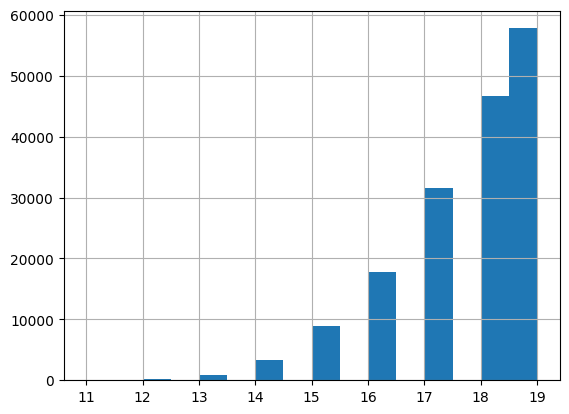

In [306]:
df_pivot_is.is_nan.hist(bins=16);

In [321]:
df_pivot_is['n_cik'] = df_pivot_is.groupby(['cik'])['cik'].transform('count')
#df_pivot_is = df_pivot_is[df_pivot_is.cik>100_000].tag.unique()
df_pivot_is[df_pivot_is.n_cik==100]
df_pivot_is[(df_pivot_is.name=='INNSUITES HOSPITALITY TRUST')&(df_pivot_is.date=='2017-07-31')].iloc[:,10:]


tag,form,period,uom,ddate,ComprehensiveIncomeNetOfTax,CostOfGoodsAndServicesSold,CostOfGoodsSold,CostOfRevenue,CostsAndExpenses,DepreciationAndAmortization,...,ResearchAndDevelopmentExpense,RevenueFromContractWithCustomerExcludingAssessedTax,Revenues,SalesRevenueGoodsNet,SalesRevenueNet,SellingAndMarketingExpense,SellingGeneralAndAdministrativeExpense,n_cik,date,is_nan
380515,10-Q,20170731.0,USD,20170731,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3931943.0,NaN,NaN,684314.5,NaN,100,2017-07-31,16
382140,10-Q,20180731.0,USD,20170731,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3526069.5,NaN,NaN,315710.0,NaN,100,2017-07-31,16


In [322]:
df_pivot_is.shape

(167222, 44)

In [323]:
df_pivot_is.columns

Index(['cik', 'name', 'sic', 'countryba', 'zipba', 'countryinc', 'former',
       'changed', 'afs', 'fye', 'form', 'period', 'uom', 'ddate',
       'ComprehensiveIncomeNetOfTax', 'CostOfGoodsAndServicesSold',
       'CostOfGoodsSold', 'CostOfRevenue', 'CostsAndExpenses',
       'DepreciationAndAmortization', 'GeneralAndAdministrativeExpense',
       'GrossProfit', 'IncomeLossFromContinuingOperations', 'InterestExpense',
       'InterestIncomeExpenseNet', 'InvestmentIncomeInterest',
       'LaborAndRelatedExpense', 'NetIncomeLoss', 'NoninterestExpense',
       'NonoperatingIncomeExpense', 'OperatingExpenses', 'OperatingIncomeLoss',
       'OtherNonoperatingIncomeExpense', 'ProfitLoss',
       'ResearchAndDevelopmentExpense',
       'RevenueFromContractWithCustomerExcludingAssessedTax', 'Revenues',
       'SalesRevenueGoodsNet', 'SalesRevenueNet', 'SellingAndMarketingExpense',
       'SellingGeneralAndAdministrativeExpense', 'n_cik', 'date', 'is_nan'],
      dtype='object', name='tag')

In [326]:
is_as_reported = df_pivot_is.groupby(['cik', 'name', 'sic', 'countryba', 'zipba', 'countryinc', 'former',
       'changed', 'afs', 'fye', 'form', 'uom', 'ddate'], as_index=False).first()

In [327]:
is_as_reported.shape

(121076, 44)

In [330]:
df_pivot_is.shape

(167222, 42)

In [271]:
COG = ['cik', 'CostOfGoodsAndServicesSold',
'CostOfGoodsSold',
'CostOfRevenue',
'CostsAndExpenses',
      'OperatingExpenses']

df_pivot_is[COG].iloc[450000:450050,:]

tag,cik,CostOfGoodsAndServicesSold,CostOfGoodsSold,CostOfRevenue,CostsAndExpenses,OperatingExpenses
455621,1620280.0,NaN,NaN,NaN,254485000.0,NaN
455622,1620280.0,NaN,NaN,NaN,351004000.0,NaN
455623,1575793.0,NaN,NaN,NaN,11162041.0,NaN
455624,1575793.0,39544.0,NaN,NaN,8715150.0,NaN
455625,6176.0,NaN,NaN,NaN,119453000.0,NaN
455626,6176.0,NaN,NaN,NaN,86712000.0,NaN
455627,1590895.0,NaN,NaN,NaN,533248000.0,NaN
455628,1590895.0,NaN,NaN,NaN,588161000.0,NaN
455629,1428439.0,105771000.0,NaN,NaN,NaN,111631000.0
455630,1428439.0,179665000.0,NaN,NaN,NaN,196266000.0


In [328]:
df_pivot_is['SGA'] = df_pivot_is.apply(lambda x: 
                                          np.nan_to_num(x.GeneralAndAdministrativeExpense) + np.nan_to_num(x.SellingAndMarketingExpense)
                                          if math.isnan(x.SellingGeneralAndAdministrativeExpense) 
                                       else x.SellingGeneralAndAdministrativeExpense, axis=1)
df_pivot_is.drop(columns=['GeneralAndAdministrativeExpense', 'SellingAndMarketingExpense', 'SellingGeneralAndAdministrativeExpense'], inplace=True)


In [329]:
df_pivot_is.isna().sum()

tag
cik                                                         0
name                                                        0
sic                                                         0
countryba                                                   0
zipba                                                       0
countryinc                                                  0
former                                                      0
changed                                                     0
afs                                                         0
fye                                                         0
form                                                        0
period                                                      0
uom                                                         0
ddate                                                       0
ComprehensiveIncomeNetOfTax                            126482
CostOfGoodsAndServicesSold                             117908
Cost

In [73]:
income_statement = [
    'Revenues',
    'COGS',
    'GrossProfit',
    'NetIncomeBeforeTax',
    'NetEarnings']

In [15]:
flow = num[num.qtrs!=0]
flow.shape

(80535664, 6)

In [74]:
flow_filtered = flow[flow.tag.isin(income_statement)]
flow_filtered.shape

(1244024, 6)

In [75]:
# SUB + NUM 
df_flow = sub.merge(flow_filtered, on='adsh', how='left')
df_flow = df_flow.dropna(subset=['tag', 'value'])
df_flow.drop_duplicates(inplace=True)
df_flow.shape

(1167548, 19)

In [77]:
df_flow['value'] = df_flow['value'].map(lambda x: x/10**6)
df_pivot_flow = df_flow.pivot_table(index=['adsh', 'cik', 'name', 'sic', 'countryba', 'zipba', 'countryinc', 'afs', 'fye', 'form', 'qtrs', 'period', 'uom', 'ddate'], columns='tag', values='value').reset_index()
df_pivot_flow.head()


tag,adsh,cik,name,sic,countryba,zipba,countryinc,afs,fye,form,qtrs,period,uom,ddate,GrossProfit,NetEarnings,NetIncomeBeforeTax,Revenues
0,0000002178-11-000032,2178,"ADAMS RESOURCES & ENERGY, INC.",5172.0,US,77027,US,4-NON,1231.0,10-Q,1.0,20110630.0,USD,20100630.0,NaN,NaN,NaN,0.000547
1,0000002178-11-000032,2178,"ADAMS RESOURCES & ENERGY, INC.",5172.0,US,77027,US,4-NON,1231.0,10-Q,1.0,20110630.0,USD,20110630.0,NaN,NaN,NaN,0.000824
2,0000002178-11-000032,2178,"ADAMS RESOURCES & ENERGY, INC.",5172.0,US,77027,US,4-NON,1231.0,10-Q,2.0,20110630.0,USD,20100630.0,NaN,NaN,NaN,0.001081
3,0000002178-11-000032,2178,"ADAMS RESOURCES & ENERGY, INC.",5172.0,US,77027,US,4-NON,1231.0,10-Q,2.0,20110630.0,USD,20110630.0,NaN,NaN,NaN,0.001521
4,0000002178-11-000049,2178,"ADAMS RESOURCES & ENERGY, INC.",5172.0,US,77027,US,4-NON,1231.0,10-Q,1.0,20110930.0,USD,20100930.0,NaN,NaN,NaN,0.000502


In [78]:
df_pivot_flow = df_pivot_flow[df_pivot_flow.columns[1:]].drop_duplicates()

In [85]:
flow_clean.cik.nunique()

4221

In [81]:
flow_clean = df_pivot_flow.drop(['NetEarnings', 'NetIncomeBeforeTax'], axis=1)
flow_clean = flow_clean.dropna()

flow_clean['date'] = flow_clean.ddate.apply(lambda x: pd.to_datetime(str(x).split('.')[0], format='%Y%m%d', errors='coerce')))
flow_clean['filing_date'] = flow_clean.period.apply(lambda x: pd.to_datetime(str(x).split('.')[0], format='%Y%m%d', errors='coerce')))

flow_clean = flow_clean.drop(['period', 'ddate', 'fye', 'form'], axis=1)
flow_clean.sort_values(['name', 'date']).reset_index(drop=True)

tag,cik,name,sic,countryba,zipba,countryinc,afs,qtrs,uom,GrossProfit,Revenues,date,filing_date
0,1307969,"024 PHARMA, INC.",3089.0,US,33401,US,5-SML,2.0,USD,1.255750e-07,3.436100e-07,2016-06-30,2016-06-30
1,1307969,"024 PHARMA, INC.",3089.0,US,33401,US,5-SML,3.0,USD,1.506900e-07,4.123320e-07,2016-09-30,2016-09-30
2,1307969,"024 PHARMA, INC.",3089.0,US,33401,US,5-SML,4.0,USD,9.051150e-07,1.079541e-06,2016-12-31,2016-12-31
3,1307969,"024 PHARMA, INC.",3089.0,US,33401,US,5-SML,1.0,USD,4.332300e-08,1.185450e-07,2017-03-31,2017-03-31
4,1084869,1 800 FLOWERS COM INC,5990.0,US,11514,US,2-ACC,4.0,USD,5.174580e-04,1.173024e-03,2016-06-30,2018-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178591,1408950,"ZURVITA HOLDINGS, INC.",7389.0,US,77024,US,5-SML,3.0,USD,7.628510e-07,4.495063e-06,2012-04-30,2012-04-30
178592,1408950,"ZURVITA HOLDINGS, INC.",7389.0,US,77024,US,5-SML,4.0,USD,1.379815e-06,7.893793e-06,2012-07-31,2012-07-31
178593,1408950,"ZURVITA HOLDINGS, INC.",7389.0,US,77024,US,5-SML,1.0,USD,1.180692e-06,6.146702e-06,2012-10-31,2012-10-31
178594,1408950,"ZURVITA HOLDINGS, INC.",7389.0,US,77024,US,5-SML,1.0,USD,1.482253e-06,7.274115e-06,2013-01-31,2013-01-31


#### Equity Report

eq = pd.read_csv(agg_path+'equity.csv', index_col=0)

In [159]:
eq.shape

(1759144, 23)

In [160]:
eq_num = eq.merge(num, on=['adsh', 'tag', 'version'], how='inner')

eq_num['n_tag'] = eq_num.groupby(['tag'])['tag'].transform('count')
eq_num.shape

(5099018, 28)

In [171]:
eq_columns = ['NetIncomeLoss', 'StockholdersEquity',
       'ProfitLoss', 'StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest']

eq_filtered = eq_num[eq_num.tag.isin(eq_columns)].drop_duplicates()
eq_filtered.shape

(2967378, 28)

In [172]:
df_pivot_eq = eq_filtered.pivot_table(index=['adsh', 'cik', 'name', 'sic', 'countryba', 'zipba', 'countryinc', 'former', 'changed', 'afs', 'fye', 'form', 'period', 'uom', 'ddate'], columns='tag', values='value').reset_index()
df_pivot_eq.shape


(578904, 19)

In [173]:
df_pivot_eq.isna().sum()

tag
adsh                                                                           0
cik                                                                            0
name                                                                           0
sic                                                                            0
countryba                                                                      0
zipba                                                                          0
countryinc                                                                     0
former                                                                         0
changed                                                                        0
afs                                                                            0
fye                                                                            0
form                                                                           0
period                  

In [174]:
df_pivot_eq['Equity'] = df_pivot_eq.apply(lambda x: 
                                          x.StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest 
                                          if math.isnan(x.StockholdersEquity) else x.StockholdersEquity, axis=1)
df_pivot_eq.drop(columns=['StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest', 'StockholdersEquity'], inplace=True)


In [178]:
df_pivot_eq['NetIncome'] = df_pivot_eq.apply(lambda x: 
                                          x.ProfitLoss 
                                          if math.isnan(x.NetIncomeLoss) else x.NetIncomeLoss, axis=1)
df_pivot_eq.drop(columns=['NetIncomeLoss', 'ProfitLoss'], inplace=True)


In [180]:
df_pivot_eq = df_pivot_eq[df_pivot_eq.columns[1:]].drop_duplicates()
df_pivot_eq.shape

(570900, 16)

In [181]:
df_pivot_eq.isna().sum()

tag
cik                0
name               0
sic                0
countryba          0
zipba              0
countryinc         0
former             0
changed            0
afs                0
fye                0
form               0
period             0
uom                0
ddate              0
Equity         91884
NetIncome     208314
dtype: int64

In [182]:
df_pivot_eq['date'] = df_pivot_eq.ddate.apply(lambda x: pd.to_datetime(str(x).split('.')[0], format='%Y%m%d', errors='coerce'))
df_pivot_eq['filing_date'] = df_pivot_eq.period.apply(lambda x: pd.to_datetime(str(x).split('.')[0], format='%Y%m%d', errors='coerce'))

eq_clean = df_pivot_eq.drop(['period', 'ddate', 'fye', 'form'], axis=1)
eq_clean = eq_clean.sort_values(['name', 'date']).reset_index(drop=True)


(570900, 14)

In [183]:
eq_clean.to_csv(agg_path+'equity_clean.csv')

#### Balance Sheet


In [44]:
balsht_num = balsht.merge(num, on=['adsh', 'tag', 'version'], how='inner')

balsht_num['n_tag'] = balsht_num.groupby(['tag'])['tag'].transform('count')


,adsh,cik,name,sic,countryba,stprba,zipba,countryinc,former,changed,...,version,tlabel,report,line,stmt,ddate,qtrs,uom,value,n_tag
0,0000891618-09-000166,93410.0,CHEVRON CORP,2911.0,US,CA,94583,US,CHEVRONTEXACO CORP,20011009.0,...,us-gaap/2008,"Accounts and Financing Receivable, after Allow...",4.0,6.0,BS,20081231,0,USD,1.585600e+10,9371
1,0000891618-09-000166,93410.0,CHEVRON CORP,2911.0,US,CA,94583,US,CHEVRONTEXACO CORP,20011009.0,...,us-gaap/2008,"Accounts and Financing Receivable, after Allow...",4.0,6.0,BS,20090331,0,USD,1.441600e+10,9371
2,0001104659-09-031513,1124198.0,FLUOR CORP,1600.0,US,TX,75039,US,NaN,NaN,...,us-gaap/2008,"Accounts and Financing Receivable, after Allow...",2.0,6.0,BS,20081231,0,USD,1.227224e+09,9371
3,0001104659-09-031513,1124198.0,FLUOR CORP,1600.0,US,TX,75039,US,NaN,NaN,...,us-gaap/2008,"Accounts and Financing Receivable, after Allow...",2.0,6.0,BS,20090331,0,USD,1.452748e+09,9371
4,0001193125-09-111401,1080224.0,EDGAR ONLINE INC,7389.0,US,CT,06854,US,NaN,NaN,...,us-gaap/2008,"Accounts and Financing Receivable, after Allow...",1.0,6.0,BS,20081231,0,USD,2.570000e+06,9371
5,0001193125-09-111401,1080224.0,EDGAR ONLINE INC,7389.0,US,CT,06854,US,NaN,NaN,...,us-gaap/2008,"Accounts and Financing Receivable, after Allow...",1.0,6.0,BS,20090331,0,USD,2.185000e+06,9371
6,0001193125-09-150935,1048286.0,MARRIOTT INTERNATIONAL INC /MD/,7011.0,US,MD,20817,US,NEW MARRIOTT MI INC,19971023.0,...,us-gaap/2008,"Accounts and Financing Receivable, after Allow...",3.0,6.0,BS,20081231,0,USD,8.980000e+08,9371
7,0001193125-09-150935,1048286.0,MARRIOTT INTERNATIONAL INC /MD/,7011.0,US,MD,20817,US,NEW MARRIOTT MI INC,19971023.0,...,us-gaap/2008,"Accounts and Financing Receivable, after Allow...",3.0,6.0,BS,20090630,0,USD,8.630000e+08,9371
8,0001193125-09-160240,931148.0,GRAFTECH INTERNATIONAL LTD,3620.0,US,OH,44130,US,UCAR INTERNATIONAL INC,19941011.0,...,us-gaap/2008,"Accounts and Financing Receivable, after Allow...",1.0,6.0,BS,20081231,0,USD,1.469860e+08,9371
9,0001193125-09-160240,931148.0,GRAFTECH INTERNATIONAL LTD,3620.0,US,OH,44130,US,UCAR INTERNATIONAL INC,19941011.0,...,us-gaap/2008,"Accounts and Financing Receivable, after Allow...",1.0,6.0,BS,20090630,0,USD,9.220800e+07,9371


In [65]:
balsht_columns = balsht_num[balsht_num.n_tag>100_000].tag.unique()

balsht_filtered = balsht_num[balsht_num.tag.isin(balsht_columns)].drop_duplicates()
balsht_filtered.shape

(12608041, 28)

In [145]:
df_pivot_bs = balsht_filtered.pivot_table(index=['adsh', 'cik', 'name', 'sic', 'countryba', 'zipba', 'countryinc', 'former', 'changed', 'afs', 'fye', 'form', 'period', 'uom', 'ddate'], columns='tag', values='value').reset_index()


In [149]:
df_pivot_bs['Equity'] = df_pivot_bs.apply(lambda x: 
                                          x.StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest 
                                          if math.isnan(x.StockholdersEquity) else x.StockholdersEquity, axis=1)
df_pivot_bs.drop(columns=['StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest', 'StockholdersEquity'], inplace=True)




df_pivot_bs['Cash_Equivalents'] = df_pivot_bs.apply(lambda x: 
                                          x.Cash if math.isnan(x.CashAndCashEquivalentsAtCarryingValue) 
                                                    else x.CashAndCashEquivalentsAtCarryingValue, axis=1)
df_pivot_bs.drop(columns=['Cash', 'CashAndCashEquivalentsAtCarryingValue'], inplace=True)




df_pivot_bs['CurrentLiabilities'] = df_pivot_bs.apply(lambda x: 
                                          x.AccruedLiabilitiesCurrent if math.isnan(x.LiabilitiesCurrent) 
                                                      else x.LiabilitiesCurrent, axis=1)
df_pivot_bs['CurrentLiabilities'] = df_pivot_bs.apply(lambda x: 
                                          x.AccountsPayableAndAccruedLiabilitiesCurrent if math.isnan(x.CurrentLiabilities) 
                                                      else x.CurrentLiabilities, axis=1)
df_pivot_bs.drop(columns=['AccruedLiabilitiesCurrent', 'LiabilitiesCurrent', 'AccountsPayableAndAccruedLiabilitiesCurrent'], inplace=True)




df_pivot_bs['AddlPaidInCapital'] = df_pivot_bs.apply(lambda x: 
                                          x.AdditionalPaidInCapitalCommonStock 
                                                     if math.isnan(x.AdditionalPaidInCapital) 
                                                    else x.AdditionalPaidInCapital, axis=1)

df_pivot_bs.drop(columns=['AdditionalPaidInCapitalCommonStock', 'AdditionalPaidInCapital'], inplace=True)



In [150]:
df_pivot_bs.drop(columns=['PrepaidExpenseCurrent', 'PrepaidExpenseAndOtherAssetsCurrent', 'PreferredStockValue', 
                          'MinorityInterest', 'OperatingLeaseRightOfUseAsset', 'OtherAssets', 'OtherAssetsCurrent',
                          'OtherAssetsNoncurrent', 'OtherLiabilitiesCurrent', 'OtherLiabilitiesNoncurrent', 
                          'LiabilitiesAndStockholdersEquity', 'EmployeeRelatedLiabilitiesCurrent', 
                          'CommonStockValue', 'DeferredRevenueCurrent', 'DeferredTaxLiabilitiesNoncurrent',
                         'LongTermDebtCurrent', 'LongTermDebtNoncurrent', 'IntangibleAssetsNetExcludingGoodwill'],
                            inplace=True)


In [151]:
df_pivot_bs = df_pivot_bs[df_pivot_bs.columns[1:]].drop_duplicates()
df_pivot_bs.shape

(706646, 28)

In [152]:
df_pivot_bs['date'] = df_pivot_bs.ddate.apply(lambda x: pd.to_datetime(str(x).split('.')[0], format='%Y%m%d', errors='coerce'))
df_pivot_bs['filing_date'] = df_pivot_bs.period.apply(lambda x: pd.to_datetime(str(x).split('.')[0], format='%Y%m%d', errors='coerce'))

bs_clean = df_pivot_bs.drop(['period', 'ddate', 'fye', 'form'], axis=1)
bs_clean = bs_clean.sort_values(['name', 'date']).reset_index(drop=True)


In [153]:
df_pivot_bs.isna().sum()

tag
cik                                                     0
name                                                    0
sic                                                     0
countryba                                               0
zipba                                                   0
countryinc                                              0
former                                                  0
changed                                                 0
afs                                                     0
fye                                                     0
form                                                    0
period                                                  0
uom                                                     0
ddate                                                   0
AccountsPayableCurrent                             510525
AccountsReceivableNetCurrent                       532060
AccumulatedOtherComprehensiveIncomeLossNetOfTax    495512
Assets    

In [154]:
bs_clean.shape


(706646, 26)

In [155]:
bs_clean.to_csv(agg_path+'balance_sheet_clean.csv')

### Pricing Data

In [61]:
price_aapl = pd.read_csv('raw_data/kaggle/Stocks/aapl.us.txt')

In [69]:
price_aapl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8364 entries, 0 to 8363
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     8364 non-null   object 
 1   Open     8364 non-null   float64
 2   High     8364 non-null   float64
 3   Low      8364 non-null   float64
 4   Close    8364 non-null   float64
 5   Volume   8364 non-null   int64  
 6   OpenInt  8364 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 457.5+ KB


In [65]:
price_aapl.Date.max()

'2017-11-10'

In [70]:
price_aapl['Date'] = pd.to_datetime(price_aapl['Date'])

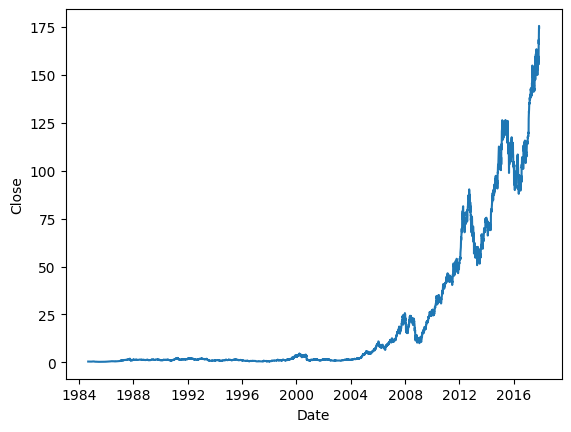

In [73]:
sns.lineplot(x='Date', y='Close', data=price_aapl);

## Data Cleaning